<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma"> Transfer Learning - Part 1</h1>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
در این نوت‌بوک رویکرد نسخت Transfer Learning یعنی استفاده به عنوان یک Feature extractor بررسی خواهد شد.
</div>

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras

<div style="direction:rtl;text-align:right;font-family:Tahoma">
کدها  برگرفته از فصل پنج کتاب
</div>

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

<div style="direction:rtl;text-align:right;font-family:Tahoma">
و گیت هاب نویسنده کتاب و توسعه دهنده کراس
</div>

[François Chollet](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

<div style="direction:rtl;text-align:right;font-family:Tahoma">است.</div>


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it,
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already
familiar with.

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [4]:
import os, shutil


In [5]:
!mkdir ~/.kaggle


In [17]:
!mv kaggle.json ~/.kaggle


In [18]:
! kaggle competitions download -c dogs-vs-cats


100% 809M/812M [00:10<00:00, 126MB/s]
100% 812M/812M [00:10<00:00, 80.3MB/s]


In [19]:
!unzip dogs-vs-cats.zip


Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [20]:
!unzip -qq train.zip


In [21]:
!rm -r dogs-vs-cats.zip sampleSubmission.csv test1.zip train.zip sample_data/


In [22]:
#for run in Colab


# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/train'

# The directory where we will
# store our smaller dataset
base_dir = '/content/subset'
os.makedirs(base_dir, exist_ok=True)

In [23]:



# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [24]:
print(train_dir, validation_dir, test_dir)

/content/subset/train /content/subset/validation /content/subset/test


تا اینجا داده ها رو آوردیم، حالا میخوایم داده ها روبدیم این شبکه و فیچر جدید کسب کنیم، چون فولی کانکتد قبلی رو برداشتیم الان دیگه سایز ورودی مهم نیست

در واقع داره داده رو میده به شبکه بالا تا براش فیچر بسازه، چون شبکه بالا فیچرسازع نه کلسیفایر


In [ ]:
مسیله اینه که این شبکه فیچرهای های لول داره میسازه و برای مسایل مختلف قابل کاربرد داره

In [25]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


In [26]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must
flatten them to `(samples, 8192)`:

در واقع اینجا ما اومدیم 2000 تا عکس که به فیچرهای چهار در چهار در پانصد و دوازده بود رسیدیم، حالا چون میخوایم بدیم فولی کانکتد، فرض می کنیم سایز ورودی چهار در چهار در پانصد و دورازده

In [28]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and
labels that we just recorded:

In [29]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 6ms/step - loss: 0.5944 - acc: 0.6805 - val_loss: 0.4472 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4194 - acc: 0.8175 - val_loss: 0.3652 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3621 - acc: 0.8410 - val_loss: 0.3288 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3185 - acc: 0.8720 - val_loss: 0.3065 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2944 - acc: 0.8835 - val_loss: 0.2901 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2714 - acc: 0.8910 - val_loss: 0.2802 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2459 - acc: 0.9050 - val_loss: 0.2716 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

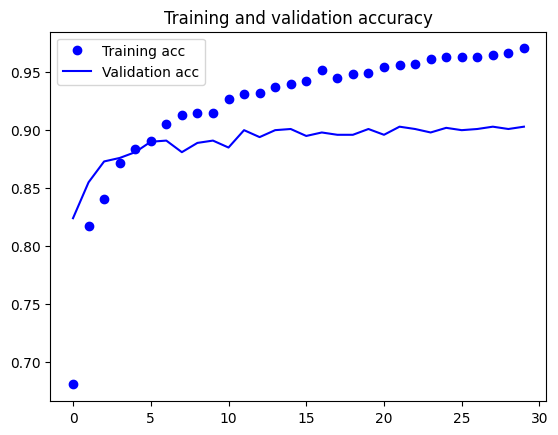

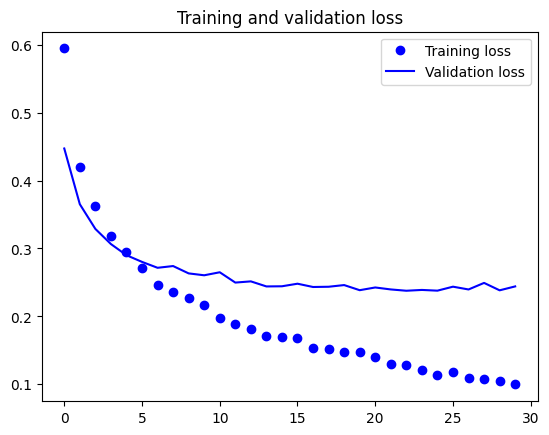

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate.
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer.
So you can do the following:

باید ایوگمنت بزنیم چون اورفیت داریم، حالا برای ائوگمنت، نمیشه از فیچر مرحله آخر استفاده کرد که باید شبکه رو بیاری داخل شبکه فولی خودت و قبل ش داده رو آیوگمنت کنی

In [32]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


تو سامری بالا 16 میلیون پارامتر داره ترین میشه
این شبکه CONVE BASE قبلا بالا یه بار روی عکسا ترین شده و لازم نیست دوباره

> Indented block



As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [34]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


حالا باید مدل رو فریز کرد که ترین نشه صرفا نه اینکه پردیکت نکنه

In [35]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


دیگه پارامترهای COVE BASE  ترین نمیشه

With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model.
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
74s - loss: 0.4465 - acc: 0.7810 - val_loss: 0.2056 - val_acc: 0.9120
Epoch 2/30
72s - loss: 0.2738 - acc: 0.8905 - val_loss: 0.1239 - val_acc: 0.9550
Epoch 3/30
72s - loss: 0.2088 - acc: 0.9145 - val_loss: 0.1194 - val_acc: 0.9560
Epoch 4/30
72s - loss: 0.1835 - acc: 0.9280 - val_loss: 0.1025 - val_acc: 0.9550
Epoch 5/30
72s - loss: 0.1642 - acc: 0.9330 - val_loss: 0.0903 - val_acc: 0.9680
Epoch 6/30
72s - loss: 0.1360 - acc: 0.9410 - val_loss: 0.0794 - val_acc: 0.9740
Epoch 7/30
72s - loss: 0.1426 - acc: 0.9465 - val_loss: 0.0968 - val_acc: 0.9560
Epoch 8/30
72s - loss: 0.1013 - acc: 0.9580 - val_loss: 0.1411 - val_acc: 0.9430
Epoch 9/30
72s - loss: 0.1177 - acc: 0.9500 - val_loss: 0.2105 - val_acc: 0.9310
Epoch 10/30
72s - loss: 0.0949 - acc: 0.9620 - val_loss: 0.0900 - val_acc: 0.9710
Epoch 11/30
72s - loss: 0.0915 - acc: 0.9655 - val_loss: 0.1204 - val_acc: 0.9630
Epoch 12/30
72s - loss:

In [ ]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

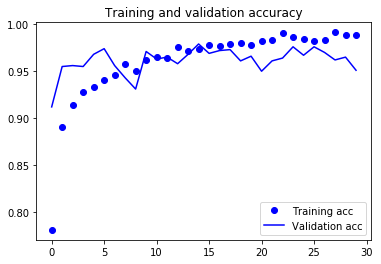

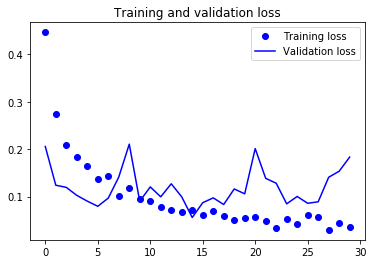

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.